# Analyzing Austin PD's Crime Reports Dataset

The dataset is available from the Austin Police Department on https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu. It is updated weekly and I last downloaded the dataset on 8/10/2020.  



## Table of Contents 

    I. Introduction
    II. Data Scrubbing
    III. Exploratory Analysis 
    IV. Summary
    
    Questions:
><ul>
><li><a href="#q1"> 1. What areas of Austin have the highest crime rates?</a></li>
><li><a href="#q2"> 2. How is crime distributed in 78753?</a></li> 
><li><a href="#q3"> 3. How is crime distributed in 78741?</a></li>
><li><a href="#q4"> 4. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed?
><li><a href="#q5"> 5. What significant does the family violence factor play, in violent crime, over time? 
><li><a href="#q6"> 6. How does murder appear on the map?
</a></li>

## I. Introduction

I began reviewing the Crime Reports dataset, provided by the Austin PD, around the same time I began reviewing its Hate Crimes datasets for analysis, at the beginning of 2020. This is a rather large dataset, containing over 2 million records, spanning from 2003 to the present, and is update weekly. 

This is a self-paced project, conceived outside of both work and the educational arenas. It is my hope that this project will reveal some actionable insights that will benefit the Austin law enforcement community, news outlets, and anyone else interested in gaining knowledge on how best to combat the problem of crime in the Austin area.

I originally attempted importing the data into this notebook using Sodapy's Socrata API method but found it cumbersome. Mainly, it didn't want to work with importing the entire dataset, and added several redundant columns. I, therefore, prefer to manually download the entire dataset and re-download each week after it's updated.

In [1]:
# Importing essential libraries and configurations
import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 
              None)

In [2]:
plt.style.use('classic')

In [3]:
# Loading the data
df = pd.read_csv('crime_reports.csv')

In [4]:
# Examining the dataframe
display(df.info())
print('----------------------------------')
display(df.duplicated().sum())
print('----------------------------------')
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2265519 entries, 0 to 2265518
Data columns (total 27 columns):
Incident Number                int64
Highest Offense Description    object
Highest Offense Code           int64
Family Violence                object
Occurred Date Time             object
Occurred Date                  object
Occurred Time                  float64
Report Date Time               object
Report Date                    object
Report Time                    float64
Location Type                  object
Address                        object
Zip Code                       float64
Council District               float64
APD Sector                     object
APD District                   object
PRA                            object
Census Tract                   float64
Clearance Status               object
Clearance Date                 object
UCR Category                   object
Category Description           object
X-coordinate                   float64
Y-coordin

None

----------------------------------


0

----------------------------------


Incident Number                      0
Highest Offense Description          0
Highest Offense Code                 0
Family Violence                      0
Occurred Date Time                 165
Occurred Date                        0
Occurred Time                       84
Report Date Time                     1
Report Date                          0
Report Time                          1
Location Type                    20856
Address                             12
Zip Code                         13806
Council District                 46867
APD Sector                        8779
APD District                      9248
PRA                              10473
Census Tract                   1399505
Clearance Status                602443
Clearance Date                  333230
UCR Category                   1495743
Category Description           1495743
X-coordinate                      9885
Y-coordinate                      9885
Latitude                         38208
Longitude                

## II. Data Scrubbing

There are several columns of data we won't be using in the analysis, mainly other date and geodata columns. So we'll drop those and also scrub some others. Mainly, we want the zip code and address columns to be free of nulls and duplicates. 

The Clearance Status column contains 3 types of statuses: Y for Yes, N for No, and O which stands for "cleared by other means than arrest." Therefore, I changed the column to bool with Y and O as True, and N as False. However, you may note that areas, where there is no clearance status at all, may or may not contain a corresponding date in the clearance date column. I am incompletely sure how best to handle this so I am open to suggestions or advice.   

In [5]:
# Helper function for scrubbing the data
def clean_data(df):
    drop_col = ['Occurred Date Time', 
                'Occurred Time', 
                'Report Date', 
                'Report Time', 
                'Census Tract', 
                'UCR Category', 
                'Category Description', 
                'X-coordinate', 
                'Y-coordinate', 
                'Location']
    df.drop(drop_col, 
            axis=1, 
            inplace=True)
    clean_col = ['Zip Code', 
                 'Report Date Time',  
                 'PRA'] 
    df.dropna(subset=clean_col, 
              inplace=True)
    df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
    """Convert the following to bools"""
    d = {'Y': True, 
         'N': False}
    e = {'C': True, 
         'O': True, 
         'N': False}
    df.clearance_status = df.clearance_status.map(e)
    df.clearance_status = df.clearance_status.astype('bool')
    df.family_violence = df.family_violence.map(d)
    df.family_violence = df.family_violence.astype('bool') 
    """Convert the following to datetime type"""
    date_col = ['occurred_date', 
                'clearance_date', 
                'report_date_time'] 
    """Convert the following to category type"""
    cat_col = ['highest_offense_description', 
               'location_type', 
               'apd_sector'] 
    df[date_col] = df[date_col].astype('datetime64') 
    df[cat_col] = df[cat_col].astype('category') 
    """Convert the following to integer type"""
    int_col = ['zip_code', 
               'pra']
    df[int_col] = df[int_col].astype('int64')
    """Set the index"""
    df.set_index(['report_date_time'], 
                 inplace=True)
    df.sort_index(inplace=True)
    return df
df = clean_data(df)

In [6]:
# Rechecking the dataframe 
display(df.isnull().sum())
print('----------------------------------')
display(df.dtypes)
print('----------------------------------')
display(df.head())
print('----------------------------------')
display(df.tail())

incident_number                     0
highest_offense_description         0
highest_offense_code                0
family_violence                     0
occurred_date                       0
location_type                   20459
address                             0
zip_code                            0
council_district                33060
apd_sector                          0
apd_district                        0
pra                                 0
clearance_status                    0
clearance_date                 330063
latitude                        27567
longitude                       27567
dtype: int64

----------------------------------


incident_number                         int64
highest_offense_description          category
highest_offense_code                    int64
family_violence                          bool
occurred_date                  datetime64[ns]
location_type                        category
address                                object
zip_code                                int64
council_district                      float64
apd_sector                           category
apd_district                           object
pra                                     int64
clearance_status                         bool
clearance_date                 datetime64[ns]
latitude                              float64
longitude                             float64
dtype: object

----------------------------------


,incident_number,highest_offense_description,highest_offense_code,family_violence,occurred_date,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,clearance_status,clearance_date,latitude,longitude
report_date_time,,,,,,,,,,,,,,,,
2002-11-29 05:30:00,2002923330284,FAMILY DISTURBANCE,3400,False,2003-01-29,RESIDENCE / HOME,6263 MC NEIL DR,78727,6.0,AD,3,183,False,NaT,30.441398,-97.747483
2003-01-01 00:01:00,2003920010029,DEADLY CONDUCT,408,False,2003-01-01,RESIDENCE / HOME,6400 CHIMNEY CREEK CIR,78723,1.0,ID,4,297,False,NaT,30.312100,-97.678260
2003-01-01 00:02:00,2003920010046,BURGLARY NON RESIDENCE,502,False,2003-01-01,COMMERCIAL / OFFICE BUILDING,730 W STASSNEY LN,78745,2.0,DA,3,511,True,2003-10-18,30.209853,-97.782088
2003-01-01 00:03:00,2003920010048,DEADLY CONDUCT,408,False,2003-01-01,RESIDENCE / HOME,1521 REAGAN HILL DR,78752,4.0,ID,2,266,True,2003-01-02,30.325735,-97.689095
2003-01-01 00:06:00,2003920010079,RESISTING ARREST OR SEARCH,905,False,2003-01-01,RESIDENCE / HOME,2407 CORONADO ST,78702,3.0,CH,2,422,True,2003-01-01,30.261713,-97.713550


----------------------------------


,incident_number,highest_offense_description,highest_offense_code,family_violence,occurred_date,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,clearance_status,clearance_date,latitude,longitude
report_date_time,,,,,,,,,,,,,,,,
2020-09-05 20:22:00,20205035325,BURGLARY OF RESIDENCE,500,False,2020-09-05,RESIDENCE / HOME,9323 MENCHACA RD,78748,5.0,FR,1,535,True,NaT,30.178575,-97.819372
2020-09-05 20:23:00,20205035326,CRIMINAL MISCHIEF,1400,False,2020-08-29,RESIDENCE / HOME,1221 S CONGRESS AVE,78704,9.0,HE,1,454,True,NaT,30.251422,-97.748658
2020-09-05 20:43:00,20205035328,ASSAULT BY CONTACT,902,False,2020-07-01,OTHER / UNKNOWN,9501 MENCHACA RD,78748,5.0,FR,1,535,True,NaT,30.176585,-97.819712
2020-09-05 22:14:00,20205035330,THEFT,600,False,2020-08-16,GOVERNMENT / PUBLIC BUILDING,812 SPRINGDALE RD,78702,3.0,CH,2,422,True,NaT,30.258932,-97.699980
2020-09-06 00:25:00,20205035332,BURGLARY OF RESIDENCE,500,False,2020-09-04,RESIDENCE / HOME,4404 E OLTORF ST,78741,3.0,HE,4,458,True,NaT,30.227065,-97.726246


## III. Exploratory Analysis

<a id='q1'></a>
### A. Question 1. What areas of Austin have the highest crime rates? 

***Note: I am only including zipcodes and crimes, for questions 1 - 3, that >= 1%. Any zipcodes or crime percentages, below 1%, will be discluded to simplify analysis and visualizations.***

Question 4 regards violent crime. For violent crime, I chose to examine 4 categories: aggrivated assault, rape, murder, and capital murder. I realize there are other types of violent crime, but for now I am sticking with these 4 categories. 

78741    203939
78753    175795
78701    166713
78758    156317
78704    152428
78745    148519
78702    135328
78744    124373
78723    116553
78752     83341
78748     66852
78759     65048
78751     63132
78757     56816
78705     56171
78721     47066
78749     39848
78724     37092
78727     35246
78703     34687
78731     28094
78746     27812
78729     25138
78750     23187
78754     22239
78722     19480
78756     17894
78617     16903
78735     15423
78747     12913
          ...  
78730      3011
78653      1834
78728      1377
78652       680
78664       369
78712       334
78733       319
78732       297
78737       212
78681       210
78610       130
78734       102
78641        66
0            62
78738        43
78621        28
78645        24
78620        17
76574        17
78640        16
78713        12
78612        11
78669         9
78634         5
78615         4
78626         3
78642         2
78619         1
78654         1
78628         1
Name: zip_code, Length: 

----------------------------------


78741    9.057108e-02
78753    7.807209e-02
78701    7.403869e-02
78758    6.942174e-02
78704    6.769460e-02
78745    6.595858e-02
78702    6.010034e-02
78744    5.523513e-02
78723    5.176220e-02
78752    3.701246e-02
78748    2.968955e-02
78759    2.888838e-02
78751    2.803747e-02
78757    2.523248e-02
78705    2.494603e-02
78721    2.090242e-02
78749    1.769684e-02
78724    1.647288e-02
78727    1.565306e-02
78703    1.540480e-02
78731    1.247679e-02
78746    1.235155e-02
78729    1.116400e-02
78750    1.029755e-02
78754    9.876533e-03
78722    8.651237e-03
78756    7.946881e-03
78617    7.506769e-03
78735    6.849488e-03
78747    5.734776e-03
             ...     
78730    1.337211e-03
78653    8.144954e-04
78728    6.115377e-04
78652    3.019939e-04
78664    1.638761e-04
78712    1.483323e-04
78733    1.416707e-04
78732    1.319003e-04
78737    9.415104e-05
78681    9.326283e-05
78610    5.773413e-05
78734    4.529909e-05
78641    2.931117e-05
0        2.753474e-05
78738    1

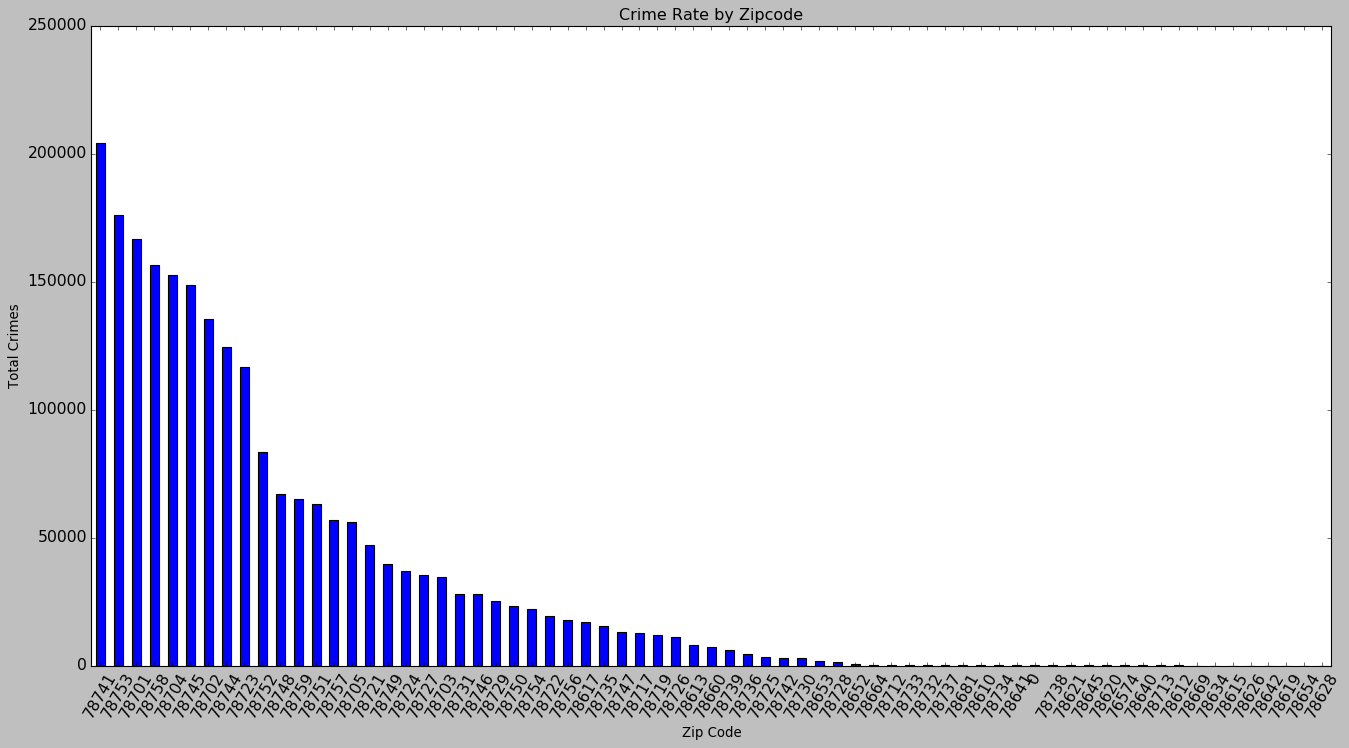

In [7]:
figsize = [20,10]

# Create and show dataframe for crime rates by zipcode and then as percentages
zip_codes = df.zip_code.value_counts()
display(zip_codes)
print('----------------------------------')
display(df.zip_code.value_counts(normalize=True))


df.zip_code.value_counts().plot.bar(fontsize=14, 
                                    figsize=figsize,   
                                    rot=60)

plt.xlabel('Zip Code')
plt.ylabel('Total Crimes')
plt.title('Crime Rate by Zipcode')
plt.show()

zip_off_desc = pd.crosstab(df.zip_code, 
                           df.highest_offense_description)

Out of all the areas in Austin, 78741 has the highest percentage of overall crime at 9.06%. This is a significant 1.3 percentage points higher than the number 2 area 78753 which hosts 7.8% of overall crime.

#### Taking a closer look at particular areas... 

Because 78753 is my resident zipcode, I chose to examine it first. 

Next, I'll examine 78741. 

<a id='q2'></a>
### B. Question 2. How is crime distributed in 78753? 

THEFT                             16931
BURGLARY OF VEHICLE               15770
FAMILY DISTURBANCE                14312
CRIMINAL MISCHIEF                  9254
THEFT BY SHOPLIFTING               7514
ASSAULT W/INJURY-FAM/DATE VIOL     7028
BURGLARY OF RESIDENCE              6009
DWI                                4874
DISTURBANCE - OTHER                4678
CUSTODY ARREST TRAFFIC WARR        4324
HARASSMENT                         4156
AUTO THEFT                         4060
POSS OF DRUG PARAPHERNALIA         3708
PUBLIC INTOXICATION                3340
ASSAULT WITH INJURY                3240
CRIMINAL TRESPASS                  3096
POSS CONTROLLED SUB/NARCOTIC       2934
RUNAWAY CHILD                      2893
WARRANT ARREST NON TRAFFIC         2785
POSSESSION OF MARIJUANA            2684
BURGLARY NON RESIDENCE             2446
VIOL CITY ORDINANCE - OTHER        1860
Name: highest_offense_description, dtype: int64

----------------------------------


THEFT                             0.096311
BURGLARY OF VEHICLE               0.089707
FAMILY DISTURBANCE                0.081413
CRIMINAL MISCHIEF                 0.052641
THEFT BY SHOPLIFTING              0.042743
ASSAULT W/INJURY-FAM/DATE VIOL    0.039978
BURGLARY OF RESIDENCE             0.034182
DWI                               0.027725
DISTURBANCE - OTHER               0.026611
CUSTODY ARREST TRAFFIC WARR       0.024597
HARASSMENT                        0.023641
AUTO THEFT                        0.023095
POSS OF DRUG PARAPHERNALIA        0.021093
PUBLIC INTOXICATION               0.018999
ASSAULT WITH INJURY               0.018431
CRIMINAL TRESPASS                 0.017611
POSS CONTROLLED SUB/NARCOTIC      0.016690
RUNAWAY CHILD                     0.016457
WARRANT ARREST NON TRAFFIC        0.015842
POSSESSION OF MARIJUANA           0.015268
BURGLARY NON RESIDENCE            0.013914
VIOL CITY ORDINANCE - OTHER       0.010581
Name: highest_offense_description, dtype: float64

Text(0.5, 1.0, 'Crime Distribution (78753)')

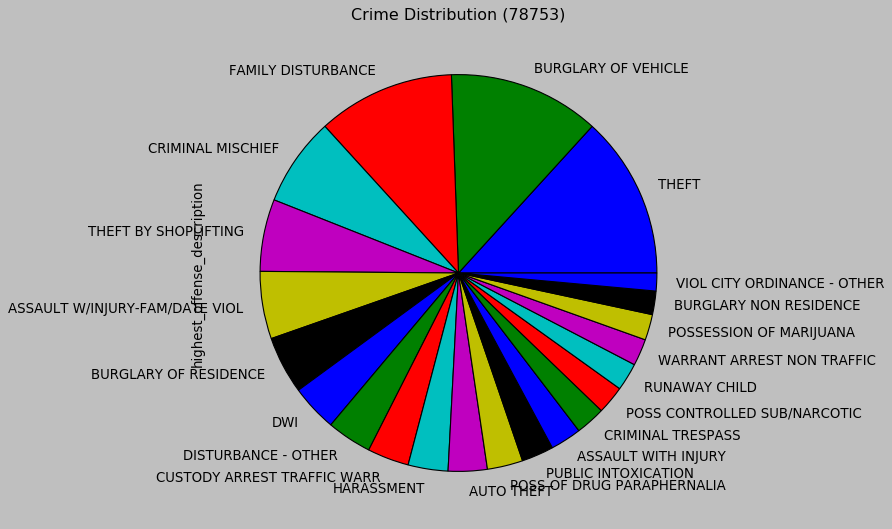

In [8]:
# Examining crime in the 78753 area
df_53 = df[df.zip_code == 78753]

# Create a dataframe for the top 10 crime categories in the zipcode
df_53_off = df_53.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages 
display(df_53_off)
print('----------------------------------')
display(df_53.highest_offense_description.value_counts(normalize=True).head(22))

df_53_off.plot.pie(figsize=(8,8))
plt.title('Crime Distribution (78753)')

<a id='q3'></a>
### C. Question 3. How is crime distributed in 78741? 

FAMILY DISTURBANCE                19990
BURGLARY OF VEHICLE               19632
THEFT                             15390
CRIMINAL MISCHIEF                 10885
ASSAULT W/INJURY-FAM/DATE VIOL     9542
BURGLARY OF RESIDENCE              8788
PUBLIC INTOXICATION                6356
CUSTODY ARREST TRAFFIC WARR        6011
DWI                                5605
HARASSMENT                         5419
DISTURBANCE - OTHER                5090
AUTO THEFT                         4487
ASSAULT WITH INJURY                4469
CRIMINAL TRESPASS                  3843
POSS CONTROLLED SUB/NARCOTIC       3820
POSSESSION OF MARIJUANA            3784
THEFT BY SHOPLIFTING               3545
POSS OF DRUG PARAPHERNALIA         3515
WARRANT ARREST NON TRAFFIC         3448
RUNAWAY CHILD                      2772
VIOL CITY ORDINANCE - OTHER        2195
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098020
BURGLARY OF VEHICLE               0.096264
THEFT                             0.075464
CRIMINAL MISCHIEF                 0.053374
ASSAULT W/INJURY-FAM/DATE VIOL    0.046789
BURGLARY OF RESIDENCE             0.043091
PUBLIC INTOXICATION               0.031166
CUSTODY ARREST TRAFFIC WARR       0.029474
DWI                               0.027484
HARASSMENT                        0.026572
DISTURBANCE - OTHER               0.024958
AUTO THEFT                        0.022002
ASSAULT WITH INJURY               0.021913
CRIMINAL TRESPASS                 0.018844
POSS CONTROLLED SUB/NARCOTIC      0.018731
POSSESSION OF MARIJUANA           0.018555
THEFT BY SHOPLIFTING              0.017383
POSS OF DRUG PARAPHERNALIA        0.017236
WARRANT ARREST NON TRAFFIC        0.016907
RUNAWAY CHILD                     0.013592
VIOL CITY ORDINANCE - OTHER       0.010763
Name: highest_offense_description, dtype: float64

Text(0.5, 1.0, 'Crime Distribution (78741)')

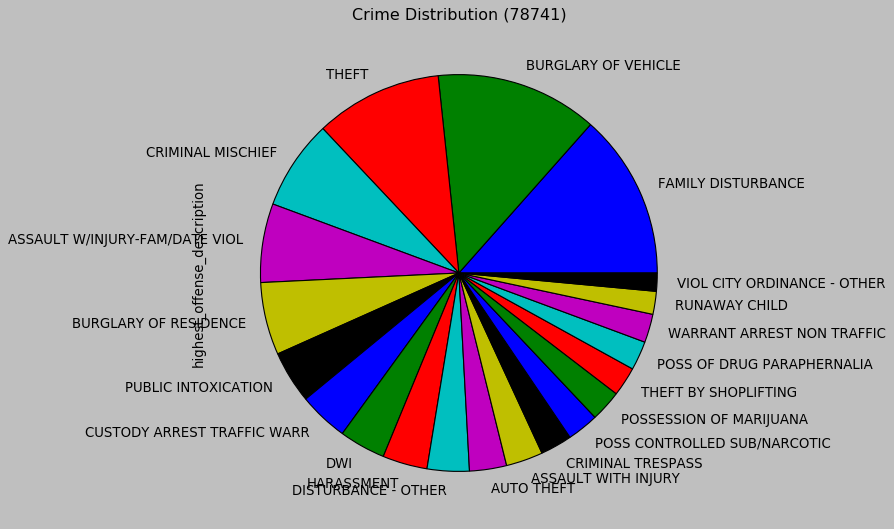

In [9]:
# Create a dataframe for crime in the 78741 area (the highest amount of crime of any Austin zip code)
df_41 = df[df.zip_code == 78741]

# Create a dataframe for the top 10 crime categories in the zipcode
df_41_off = df_41.highest_offense_description.value_counts().head(21)

# Display the different crime values & then as percentages 
display(df_41_off)
print('----------------------------------')
display(df_41.highest_offense_description.value_counts(normalize=True).head(21))

df_41_off.plot.pie(figsize=(8,8))
plt.title('Crime Distribution (78741)')

<a id='q4'></a>
### D. Question 4. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed? 

***The following line of code shows crime rates only >= 1% per zipcode.***

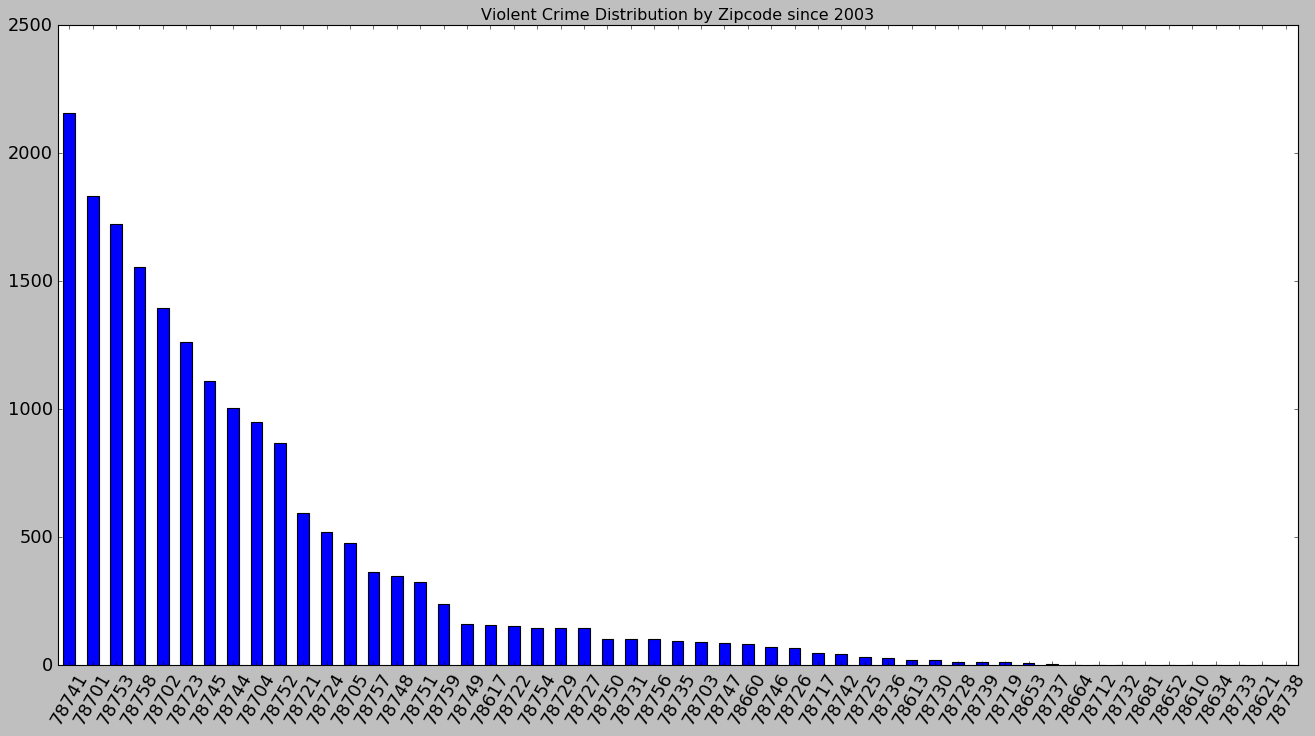

highest_offense_description,AGG ASSAULT,CAPITAL MURDER,MURDER,RAPE
zip_code,,,,
78610,1,0,0,0
78613,14,0,1,6
78617,117,0,6,36
78621,1,0,0,0
78634,1,0,0,0
78652,2,0,0,0
78653,8,0,1,1
78660,64,0,2,17
78664,3,0,0,0


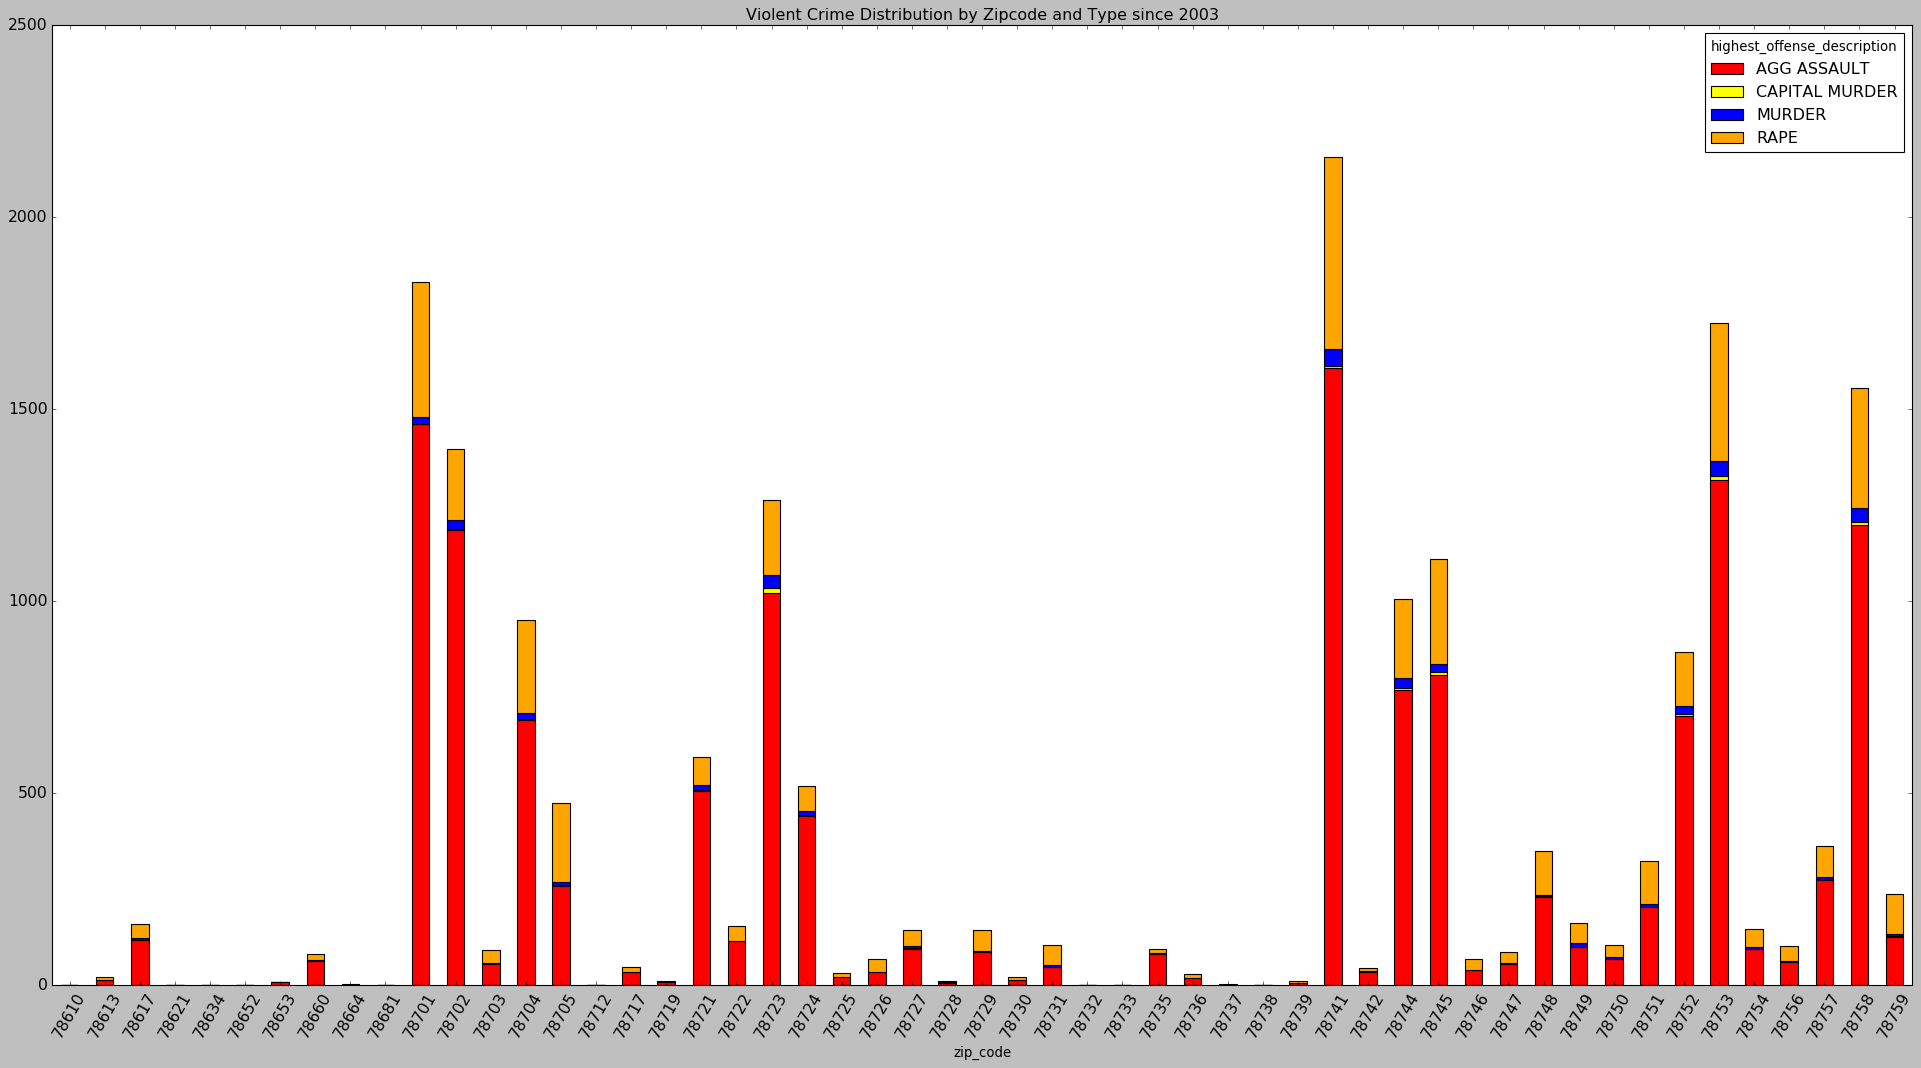

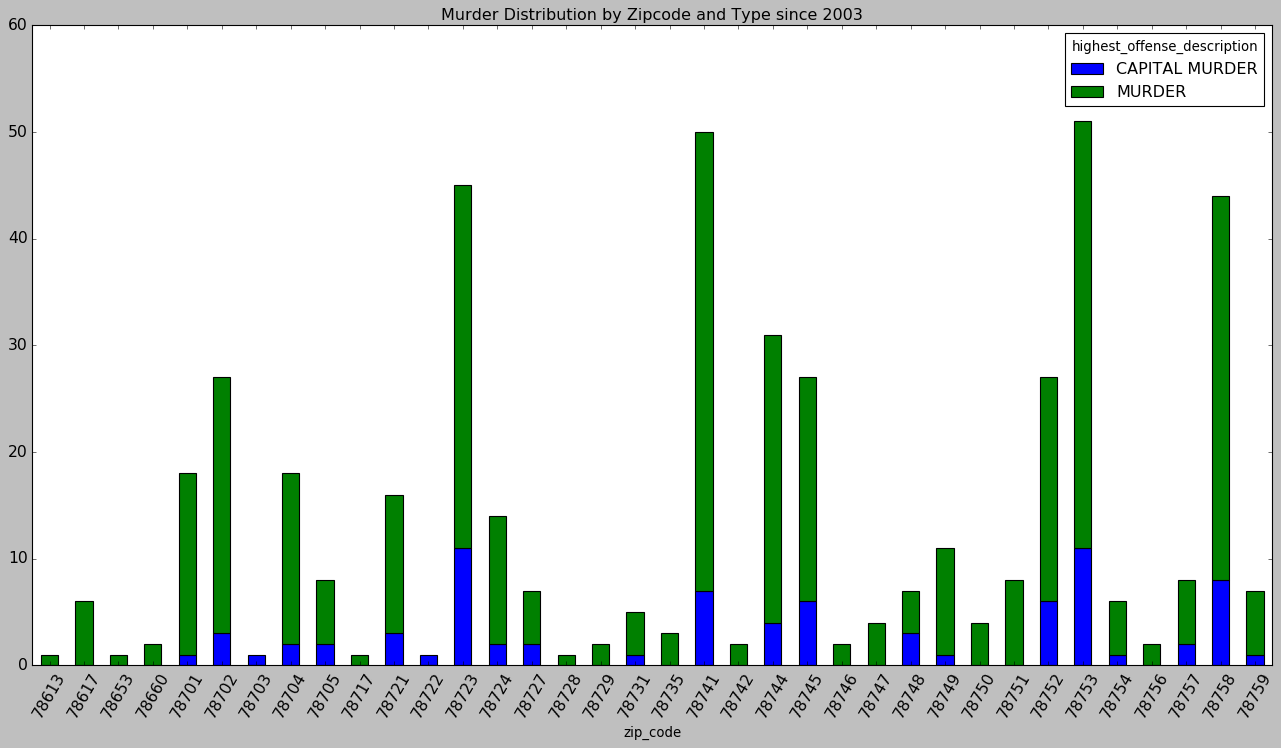

In [10]:
color = ['red', 'yellow', 'blue', 'orange', 'gold']

df_viol = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER", "RAPE", "AGG ASSAULT"]') 
df_viol_mur = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER"]')
df_mur = df[df.highest_offense_description == 'MURDER']
df_mur_cap = df[df.highest_offense_description == 'CAPITAL MURDER']
df_agg_asslt = df[df.highest_offense_description == 'AGG ASSAULT']
df_rape = df[df.highest_offense_description == 'RAPE']

df_viol_zip = df_viol.zip_code.value_counts()

df_viol_zip.plot.bar(figsize=figsize, 
                     fontsize=16,  
                     rot=60)
plt.title('Violent Crime Distribution by Zipcode since 2003')
plt.show()

viol_freq = pd.crosstab(df_viol.zip_code, df_viol.highest_offense_description)
display(viol_freq)

viol_freq.plot.bar(figsize=(30,15), 
                   fontsize=14, 
                   color=color, 
                   stacked=True, 
                   rot=60)
plt.title('Violent Crime Distribution by Zipcode and Type since 2003')
plt.show()

viol_mur_freq = pd.crosstab(df_viol_mur.zip_code, df_viol_mur.highest_offense_description)
#display(viol_mur_freq)

viol_mur_freq.plot.bar(figsize=figsize,
                       fontsize=14, 
                       stacked=True,  
                       rot=60)
plt.title('Murder Distribution by Zipcode and Type since 2003')
plt.show()

<a id='q5'></a>
### E. Question 5. What significance has the family violence factor played over time? 

0.05827905214768746

----------------------------------


report_date_time
2002    0.000000
2003    0.039757
2004    0.045092
2005    0.049538
2006    0.054202
2007    0.058873
2008    0.057992
2009    0.054702
2010    0.052464
2011    0.060115
2012    0.061430
2013    0.057860
2014    0.057470
2015    0.062610
2016    0.066007
2017    0.067766
2018    0.074773
2019    0.070976
2020    0.075288
Name: family_violence, dtype: float64

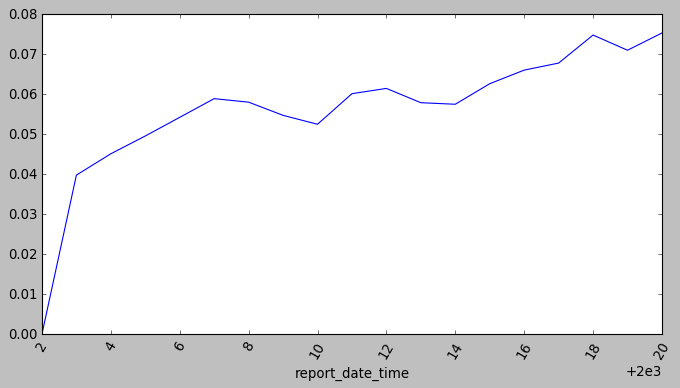

In [11]:
# Taking a look at first at the overall crime set
display(df.family_violence.mean())

print('----------------------------------')
display(df.groupby(df.index.year).family_violence.mean())

hrly_fam_viol_occurrences = df.groupby(df.index.year).family_violence.mean()

fam_viol_avg = df.groupby(df.index.year).family_violence.mean()

fam_viol_avg.plot(rot=60, figsize=(10,5))

plt.show()

0.07797552241996686

----------------------------------


report_date_time
2003    0.031461
2004    0.037428
2005    0.048591
2006    0.043393
2007    0.054319
2008    0.067379
2009    0.064317
2010    0.060918
2011    0.080472
2012    0.085149
2013    0.107514
2014    0.121305
2015    0.128151
2016    0.101449
2017    0.092965
2018    0.123711
2019    0.082301
2020    0.075281
Name: family_violence, dtype: float64

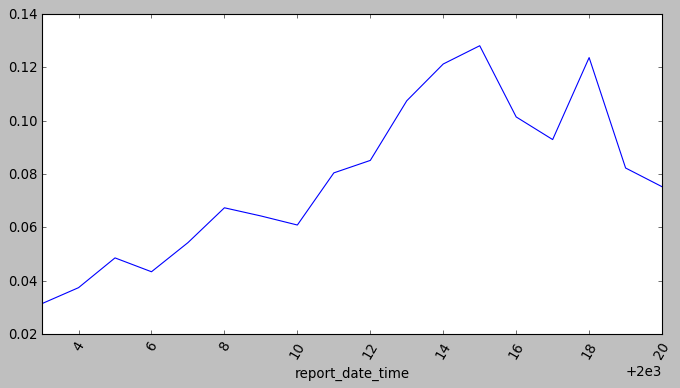

In [12]:
# Now taking a look at violent crime specifically 
display(df_viol.family_violence.mean())

print('----------------------------------')
display(df_viol.groupby(df_viol.index.year).family_violence.mean())

viol_hrly_fam_viol_occurrences = df_viol.groupby(df_viol.index.year).family_violence.mean()

viol_fam_viol_avg = df_viol.groupby(df_viol.index.year).family_violence.mean()

viol_fam_viol_avg.plot(rot=60, 
                       figsize=(10,5))

plt.show()

<a id='q6'></a>
### F. Question 6. How does murder appear on the map? 

In [13]:
# Create a geodataframe from the df_mur dataframe
gdf_mur = gp.GeoDataFrame(df_mur, 
                          geometry=gp.points_from_xy(df_mur.longitude, 
                                                     df_mur.latitude))

# ...df_mur_cap...
gdf_mur_cap = gp.GeoDataFrame(df_mur_cap, 
                              geometry=gp.points_from_xy(df_mur_cap.longitude, 
                                                         df_mur_cap.latitude))

In [14]:
gdf_mur.crs = {'init': 'epsg:3857'}
gdf_mur_cap.crs = {'init': 'epsg:3857'}

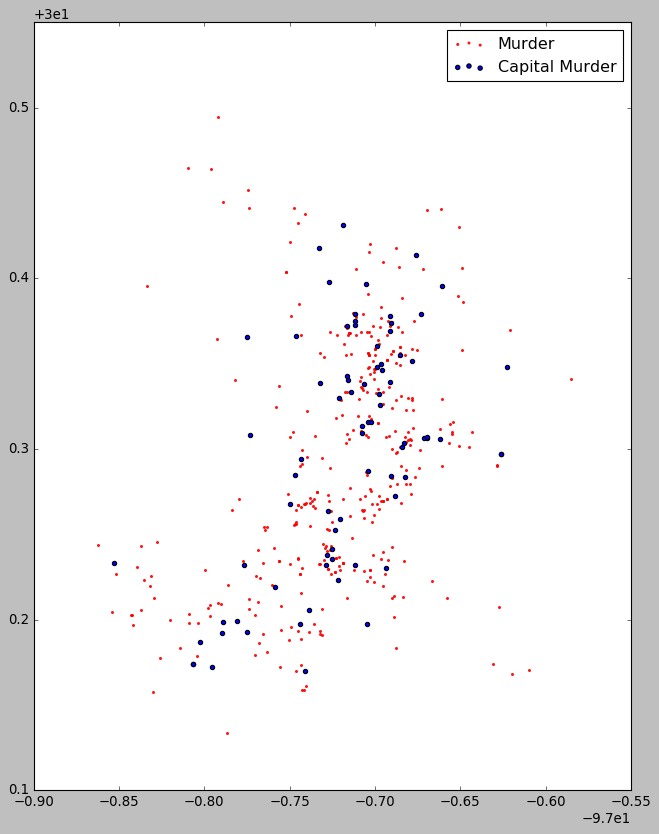

In [16]:
# Plot geodataframes on the "map"
ax = gdf_mur.plot(label='Murder', 
                  figsize=(12,12),  
                  alpha=0.85, 
                  color='r',  
                  markersize=3)  
gdf_mur_cap.plot(label='Capital Murder', 
                 figsize=(12,12),  
                 alpha=1, 
                 markersize=15, 
                 ax=ax)
ax.legend()

## IV. Summary
Needless to say, violent crimes go hand-in-hand with other violent crimes.

So far, 78753 and 78741 are the top hotspots for all sorts of crime in Austin, including violent crime.

For non-capital murder, 78741 comes in at number 1 with 10.91%. 

#### ***It is important to note that murder does not necessarily make the defendant(s) automatically eligible for the death penalty. Under Texas law, we distinguish capital murder, through the motives and actions of the defendant(s) during the commission of a homicide, as whether or not automatically warranting an eventual date with the executioner. This includes such things as if the homicide was premeditated or not, if the defendant(s) murdered a police officer, etc.***

Regarding capital murder, 78723 comes in to share the number one spot with 78753, with a rate of 13.92% each. The 78741 area drops to the number 3 spot, carrying 8.97%. So, if we're honest, 78753 actually is the number 1 hotspot for murder because it has played host to 40 non-capital murders and 11 capital murders in total, meaning it has hosted 11% of all murders. 78741, if we combine all murders, only accounts for 10.56% of the total since 2003. 

Next, 78741 climbs back to claim the number 1 spot for rape at 12.09% -- 3.43 percentage points higher than the number 2 spot 78753 carrying 8.66% which is quite a significant lead when you look at it on the graph!! Why does rape occur so much more often in this area than in others?

A peculiar outlier is zipcode 78731. Although violent crime frequency ranks amongst the lowest there, rape accounts for over 50% of violent crimes committed in that area. Why is that? 

Astonishingly the family violence factor played an ever increasing role over over time, in regards to violent crime. From 2003 to 2015, family violence increased by nearly 10 percentage points--meaning you were likely to be the victim of a family member, during the commission of a rape, aggrivated assault, murder, or capital murder, only 3.15% of the time in 2003. But by 2015, that same likelihood rose to 12.82%!